In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast
import numpy as np

csv_file_path = 'charging_sessions.csv'

df = pd.read_csv(csv_file_path, delimiter=',', quotechar='"')


# Hilfsfunktion zum Erstellen der userInput Tabelle
def parse_user_inputs(row):
    
    user_inputs = row['userInputs']
    id = row['id']

    if isinstance(user_inputs, str):
        try:
            # Konvertieren des Strings in ein Python-Dictionary
            user_inputs_data = ast.literal_eval(user_inputs)

            for entry in user_inputs_data:
                entry['reference_id'] = id
            
            return user_inputs_data
        except Exception as e:
            print(f"Fehler beim Parsen von userInputs für ID {id}: {e}")
            return []
    else:
        return []
    

# Funktion zur Umwandlung der Zeitzone
def convert_timezone(time):
    if pd.notna(time):
        return time.tz_convert('America/Los_Angeles')
    return time


# Konvertieren der Datentypen in charging_sessions
df['id'] = df['id'].astype(str)
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True).apply(convert_timezone)
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True).apply(convert_timezone)
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True).apply(convert_timezone)
df['kWhDelivered'] = df['kWhDelivered'].astype(float)
df['sessionID'] = df['sessionID'].astype(str)
df['siteID'] = df['siteID'].astype(str)
df['spaceID'] = df['spaceID'].astype(str)
df['stationID'] = df['stationID'].astype(str)
df['timezone'] = df['timezone'].astype(str)
df['userID'] = df['userID'].astype(str)

    

# Löscht Spalten Unnamed, stationID, sessionID   
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop(['sessionID', 'stationID', 'timezone'], axis=1, inplace=True)

# Löscht alle Duplikate
df = df.drop_duplicates()

# Setzt überall, wo die doneChargingTime später als die disconnectTime ist, die doneChargingTime auf die disconnectTime
df.loc[df['doneChargingTime'] > df['disconnectTime'], 'doneChargingTime'] = df['disconnectTime']


# Erstelle DataFrame user_inputs_df
user_inputs_list = df.apply(parse_user_inputs, axis=1)
user_inputs_df = pd.DataFrame([item for sublist in user_inputs_list for item in sublist])


# löscht userInputs, da in eigener Tabelle
df = df.drop('userInputs', axis=1)

# löscht paymentRequired, da immer true
user_inputs_df = user_inputs_df.drop('paymentRequired', axis=1)

# Konvertieren der Datentypen in user_inputs_df
user_inputs_df['WhPerMile'] = user_inputs_df['WhPerMile'].astype(float)
user_inputs_df['kWhRequested'] = user_inputs_df['kWhRequested'].astype(float)
user_inputs_df['milesRequested'] = user_inputs_df['milesRequested'].astype(float)
user_inputs_df['minutesAvailable'] = user_inputs_df['minutesAvailable'].astype(float)
user_inputs_df['modifiedAt'] = pd.to_datetime(user_inputs_df['modifiedAt'], utc=True).apply(convert_timezone)
user_inputs_df['requestedDeparture'] = pd.to_datetime(user_inputs_df['requestedDeparture'], utc=True).apply(convert_timezone)

# Handle missing values (in progress)
dfNan = df[df.isna().any(axis=1)]

user_inputs_df = user_inputs_df.drop('userID', axis=1, errors='ignore')

# Sortieren des user_inputs_df nach 'reference_id' und 'modifiedAt', um den neuesten Eintrag für jede ID zu erhalten
user_inputs_df_sorted = user_inputs_df.sort_values(by=['reference_id', 'modifiedAt'], ascending=[True, False])

# Behalten nur des neuesten Eintrags für jede reference_id
user_inputs_df_latest = user_inputs_df_sorted.drop_duplicates(subset=['reference_id'])

# Merge des df mit user_inputs_df_latest
# left join, um sicherzustellen, dass alle Zeilen aus df beibehalten werden
merged_df = pd.merge(df, user_inputs_df_latest, how='left', left_on='id', right_on='reference_id')

# Entfernen der Spalte 'reference_id', da sie identisch mit 'id' ist
merged_df.drop('reference_id', axis=1, inplace=True)

In [ ]:
#### KPIs ####


# KPI - Difference of doneChargingTime and disconnectTime in hours
# Car is fully charged but still connected

# Calculcate difference of disconnect and doneCharging time
merged_df['diff_connection'] = merged_df['disconnectTime'] - merged_df['doneChargingTime']
diff_connection = merged_df['diff_connection'].dropna().sort_values(ascending=True)

max = diff_connection.max()
min = diff_connection.min()

# Group by hour and count values
diff_connection_count = diff_connection.apply(lambda x : (x/np.timedelta64(1, 'h'))).astype(int).value_counts().sort_index()
diff_connection_count_zoom = diff_connection_count[diff_connection_count.values > 50]

## Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Time between full charge and disconnection
axs[0].plot(diff_connection_count.index, diff_connection_count.values)
axs[0].set_xlabel('Total hours (rounded)')
axs[0].set_ylabel('Number of Charging Sessions')
axs[0].set_title('Time between full charge and disconnection')
axs[0].text(0.5, 0.9, f'Max: {max}\n Min: {min}',  horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

# Time between full charge and disconnection with values over 50 hours only
axs[1].bar(diff_connection_count_zoom.index, diff_connection_count_zoom.values)
axs[1].set_xlabel('Total hours (rounded)')
axs[1].set_ylabel('Sum of Charging Sessions')
axs[1].set_title('Time between full charge and disconnection (zoom)')
plt.show()


# KPI - recurring users (in progress)

users_df = merged_df.loc[:, ('userID', 'connectionTime')] 
users_df['connectionTime'] = users_df['connectionTime'].dt.date
# recurring_users = users_df[users_df.groupby('userID').userID.transform(len) > 1]
recurring_users = users_df['userID'].value_counts().sort_values()


# KPI - Difference of kWhRequested and kWhDelivered

# Create new Dataframe with values where user inputs are provided
rows_with_userInputs = merged_df.loc[merged_df.modifiedAt.notna() & (merged_df.modifiedAt != '')].copy()

# Calculate difference of kWhDelivered and kWhRequested
rows_with_userInputs['kwhDiff'] = rows_with_userInputs['kWhDelivered'] - rows_with_userInputs['kWhRequested']

# Filter where difference of disconnect and doneCharging time equals zero
diff_connection_zero = rows_with_userInputs[rows_with_userInputs['diff_connection'] == pd.Timedelta(0)]
diff_connection_notZero = rows_with_userInputs[rows_with_userInputs['diff_connection'] > pd.Timedelta(0)]

diff_connection_zero_count = diff_connection_zero['kwhDiff'].value_counts().sort_index()
diff_connection_notZero_count = diff_connection_notZero['kwhDiff'].value_counts().sort_index()

## Plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle('Difference of delivered and requested kWh')

# Difference of disconnect and doneCharging time does not equal zero
axs[0, 0].bar(diff_connection_notZero_count.index, diff_connection_notZero_count.values)
axs[0, 0].set_xlabel('Difference of delivered and requested kWh')
axs[0, 0].set_ylabel('Total number')
axs[0, 0].set_title('Disconnected at full charge')

# Difference of disconnect and doneCharging time equals zero
axs[0, 1].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red')
axs[0, 1].set_xlabel('Difference of delivered and requested kWh')
axs[0, 1].set_ylabel('Total number')
axs[0, 1].set_title('Disconnected after full charge')
axs[0, 1].set_ylim(0, 35)

# Difference of disconnect and doneCharging time in different colors
axs[1, 0].bar(diff_connection_notZero_count.index, diff_connection_notZero_count.values, color='blue', label='Disconnected at full charge')
axs[1, 0].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red', label='Disconnected after full charge')
axs[1, 0].set_xlabel('Difference of delivered and requested kWh')
axs[1, 0].set_ylabel('Total number')
axs[1, 0].set_title('Overlaid view')
axs[1, 0].legend()

# Difference of disconnect and doneCharging time equals zero with a different scale
axs[1, 1].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red')
axs[1, 1].set_xlabel('Difference of delivered and requested kWh')
axs[1, 1].set_ylabel('Total number')
axs[1, 1].set_title('Disconnected after full charge (zoom)')
axs[1, 1].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


# KPI - Charging Speed

# Remove rows with no value for doneChargingTime
merged_df['doneChargingTime'] = merged_df['doneChargingTime'].replace('', pd.NaT)
rows_with_doneChargingTime = merged_df.dropna(subset=['doneChargingTime']).copy()

# Calculate difference of doneChargingTime and connectionTime -> total charging time
rows_with_doneChargingTime['chargingTime'] = (rows_with_doneChargingTime['doneChargingTime'] - rows_with_doneChargingTime['connectionTime']).dt.total_seconds()

# Remove rows with negative or zero charging time
rows_with_doneChargingTime = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.chargingTime > 0]

# Filtern der Daten für jede Site
df_site1_with_doneChargingTim = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.siteID == '1'].copy()
df_site2_with_doneChargingTim = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.siteID == '2'].copy()

# Calculate charging speed per minute and hour
rows_with_doneChargingTime['chargingSpeed(kW/Minute)'] = rows_with_doneChargingTime['kWhDelivered']  / (rows_with_doneChargingTime['chargingTime'] / 60 )
rows_with_doneChargingTime['chargingSpeed(kW)'] = rows_with_doneChargingTime['kWhDelivered']  / (rows_with_doneChargingTime['chargingTime'] / 3600 )
df_site1_with_doneChargingTim['chargingSpeed(kW)'] = df_site1_with_doneChargingTim['kWhDelivered']  / (df_site1_with_doneChargingTim['chargingTime'] / 3600 )
df_site2_with_doneChargingTim['chargingSpeed(kW)'] = df_site2_with_doneChargingTim['kWhDelivered']  / (df_site2_with_doneChargingTim['chargingTime'] / 3600 )

# Group by SpaceID and calculate mean charging time
grouped_chargingSpeed_mean_min = rows_with_doneChargingTime.groupby('spaceID')['chargingSpeed(kW/Minute)'].mean().sort_values()
grouped_chargingSpeed_mean_hour = rows_with_doneChargingTime.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()
grouped_chargingSpeed_mean_site1 = df_site1_with_doneChargingTim.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()
grouped_chargingSpeed_mean_site2 = df_site2_with_doneChargingTim.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()

## Plot
fig, axs = plt.subplots(2, 1, figsize=(25, 15))

# Mean charging speed per minute and space
axs[0].bar(grouped_chargingSpeed_mean_min.index, grouped_chargingSpeed_mean_min.values)
axs[0].set_xlabel('Space ID')
axs[0].set_ylabel('Charging speed (kW/Minute)')
axs[0].set_title('Mean charging speed per minute and Space')
axs[0].set_xticks(grouped_chargingSpeed_mean_min.index)
axs[0].set_xticklabels(grouped_chargingSpeed_mean_min.index, rotation=45, ha='right') 

# Mean charging speed per hour and space
axs[1].bar(grouped_chargingSpeed_mean_hour.index, grouped_chargingSpeed_mean_hour.values)
axs[1].set_xlabel('Space ID')
axs[1].set_ylabel('Charging speed (kW)')
axs[1].set_title('Mean charging speed per hour and Space')
axs[1].set_xticks(grouped_chargingSpeed_mean_hour.index)
axs[1].set_xticklabels(grouped_chargingSpeed_mean_hour.index, rotation=45, ha='right') 

## Plot per site
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

# Mean charging speed per space for Site 1
axs[0].bar(grouped_chargingSpeed_mean_site1.index, grouped_chargingSpeed_mean_site1.values)
axs[0].set_xlabel('Space ID')
axs[0].set_ylabel('Charging speed (kW)')
axs[0].set_title('Mean charging speed per Space for Site 1')
axs[0].set_xticks(grouped_chargingSpeed_mean_site1.index)
axs[0].set_xticklabels(grouped_chargingSpeed_mean_site1.index, rotation=45, ha='right') 

# Mean charging speed per space for Site 2
axs[1].bar(grouped_chargingSpeed_mean_site2.index, grouped_chargingSpeed_mean_site2.values)
axs[1].set_xlabel('Space ID')
axs[1].set_ylabel('Charging speed (kW)')
axs[1].set_title('Mean charging speed per Space for Site 2')
axs[1].set_xticks(grouped_chargingSpeed_mean_site2.index)
axs[1].set_xticklabels(grouped_chargingSpeed_mean_site2.index, rotation=45, ha='right') 

plt.show()


# KPI - registered and non-registered users

# Create new Dataframes for registered and non-registered users
rows_with_userId = merged_df.loc[merged_df.userID != 'nan'].copy()
rows_without_userId = merged_df.loc[merged_df.userID == 'nan'].copy()

# Calculate number of connected registered and non-registered users each hour
connection_counts_userId = rows_with_userId['connectionTime'].dt.hour.value_counts().sort_index()
connection_counts_noUserId = rows_without_userId['connectionTime'].dt.hour.value_counts().sort_index()

## Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
maxY = connection_counts_userId.values.max()+(connection_counts_userId.values.max()/10)

# Connection Time per Hour by registered Users
axs[0].bar(connection_counts_userId.index, connection_counts_userId.values)
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Number of Connections')
axs[0].set_title('Connection Time per Hour by registered Users')
axs[0].set_ylim(0, maxY)

# Connection Time per Hour by non-registered Users
axs[1].bar(connection_counts_noUserId.index, connection_counts_noUserId.values)
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Number of Connections')
axs[1].set_title('Connection Time per Hour by non-registered Users')
axs[1].set_ylim(0, maxY)

plt.show()

In [4]:
#### CLUSTER ANALYSIS ####


import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# sns.pairplot(data=merged_df)

dropped_df = merged_df.sample(n=3_000)
#dropped_df = merged_df.copy()
dropped_df.drop('id', axis=1, inplace=True)
dropped_df.drop('siteID', axis=1, inplace=True)
dropped_df.drop('spaceID', axis=1, inplace=True)
dropped_df.drop('userID', axis=1, inplace=True)
dropped_df.drop('connectionTime', axis=1, inplace=True)
dropped_df.drop('disconnectTime', axis=1, inplace=True)
dropped_df.drop('doneChargingTime', axis=1, inplace=True)
dropped_df.drop('modifiedAt', axis=1, inplace=True)
dropped_df.drop('requestedDeparture', axis=1, inplace=True)
dropped_df = dropped_df.dropna()

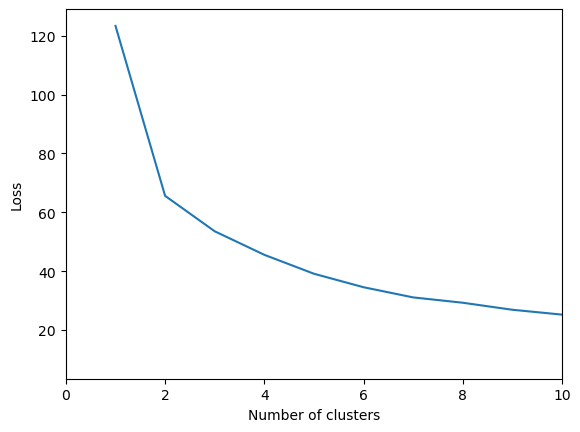

c:\Users\Emma Lux\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Emma Lux\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Emma Lux\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


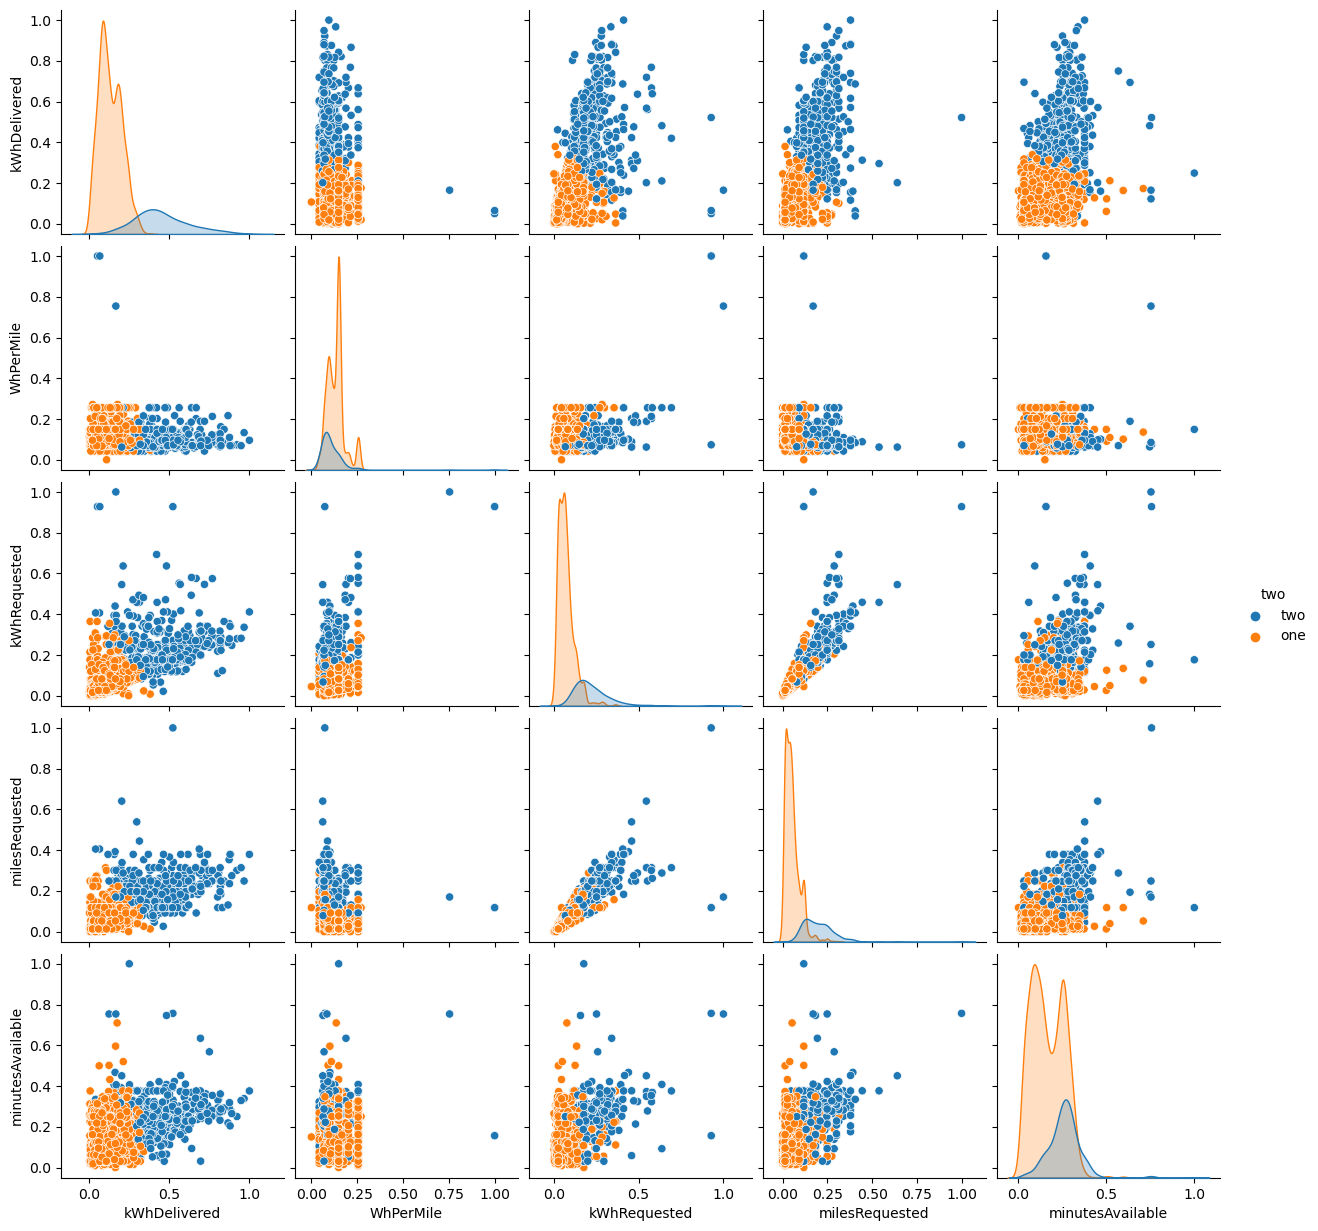

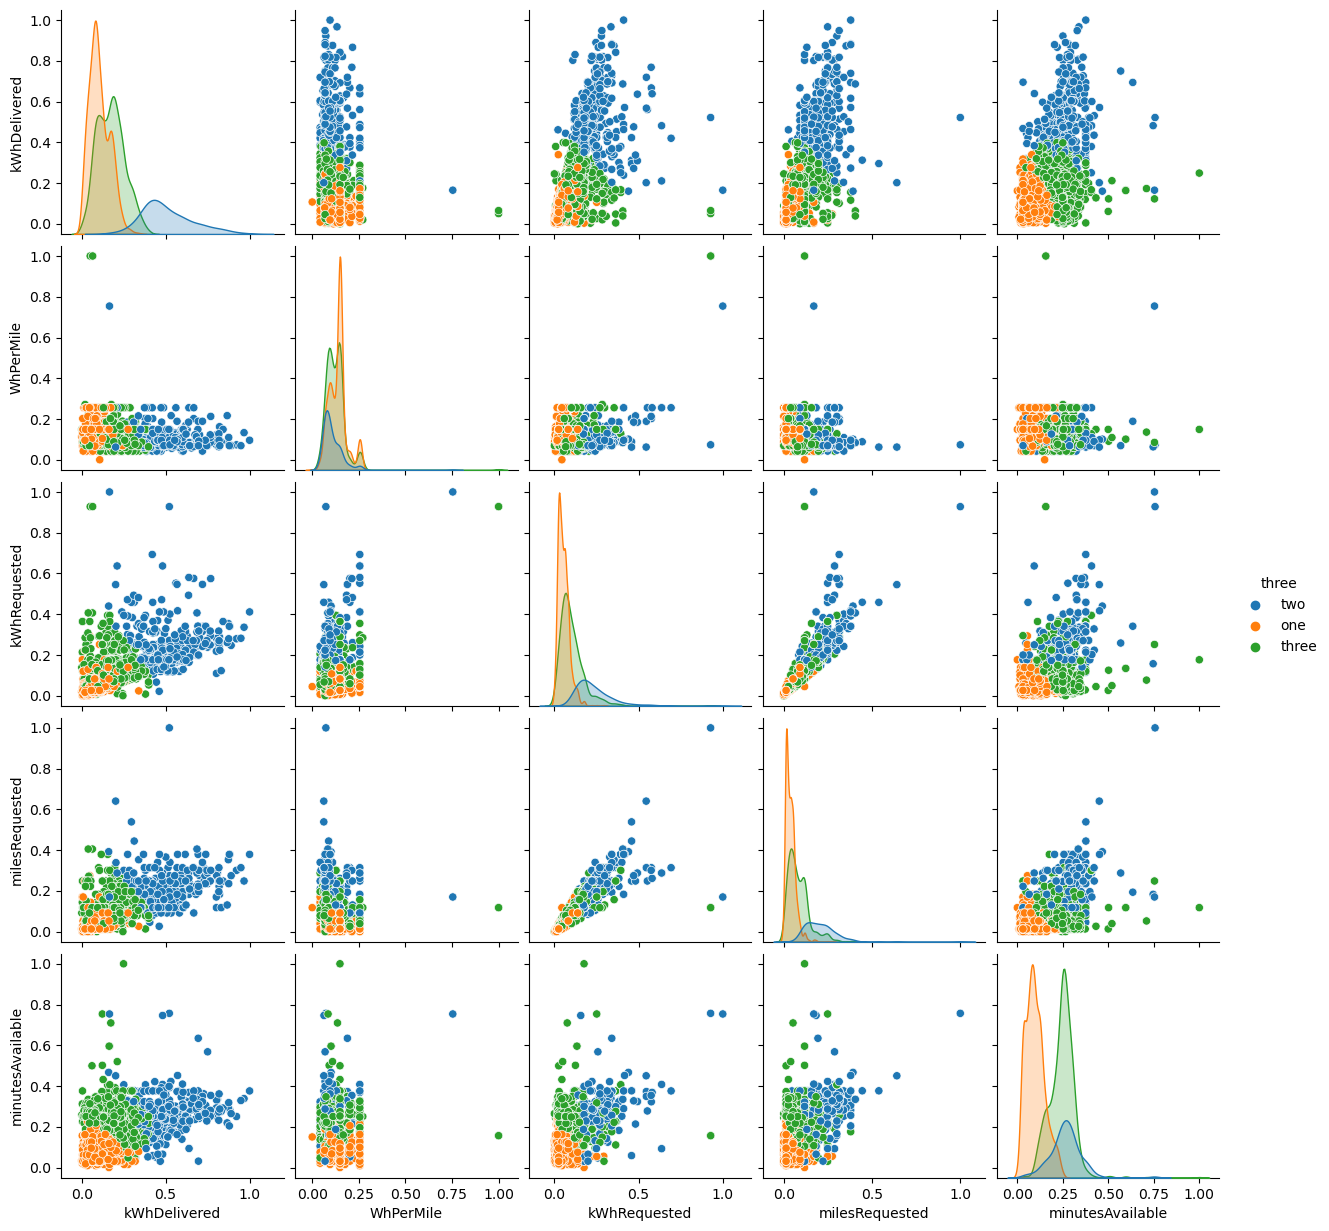

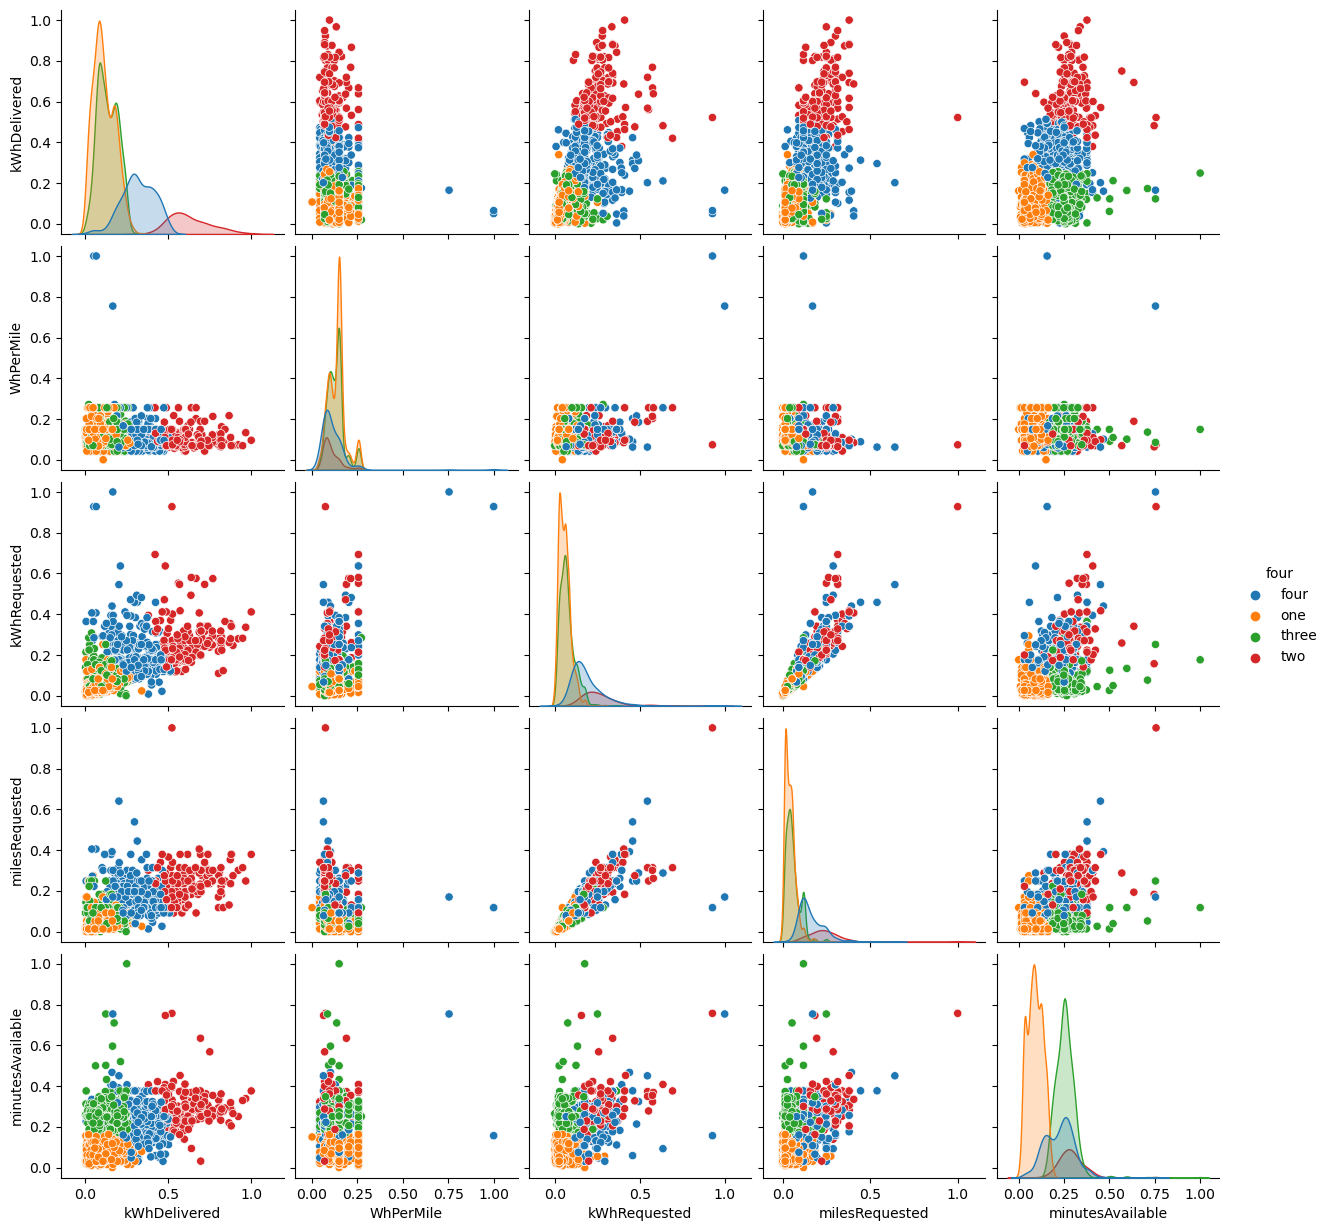

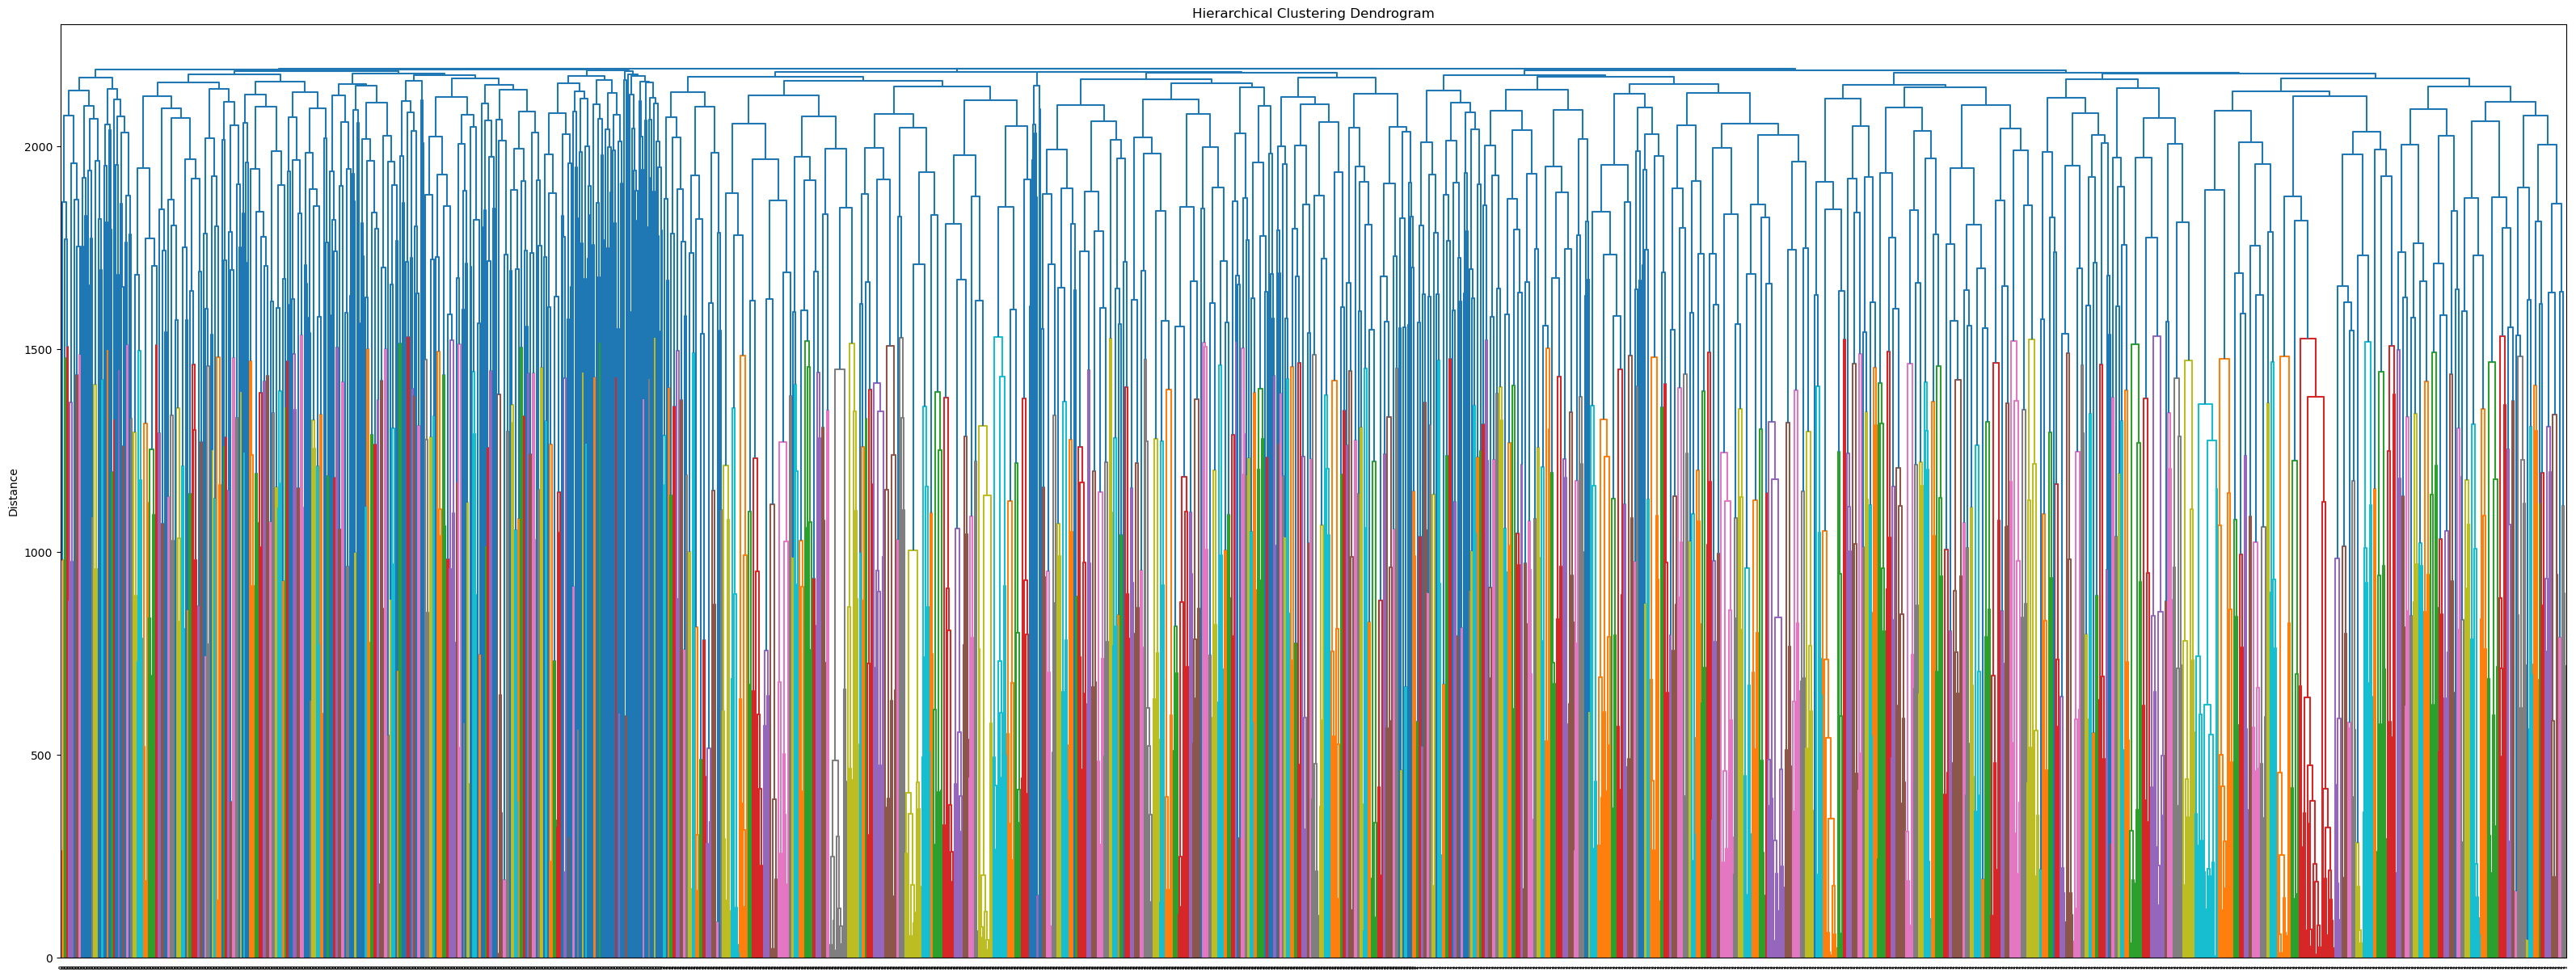

In [5]:
# scaler = StandardScaler()
# scaler.fit(dropped_df)
# scaled = scaler.transform(dropped_df)
# scaled_df = pd.DataFrame(scaled, columns=dropped_df.columns, index=dropped_df.index)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(dropped_df)
scaled_df = pd.DataFrame(scaled, columns=dropped_df.columns, index=dropped_df.index)

# ergibt keinen Sinn (ändert nichts), aber führt sonst Fehler
scaled_reshape  = np.reshape(scaled, (-1, 5))
# print('x', scaled.ndim)
# print('reshape', scaled_reshape.ndim)

# sns.pairplot(data=scaled_df)

# How many clusters? (use combination of all three)
# 1. Use expert knowledge
# 2. Plot residual loss for different number of clusters, find 'elbow' and select corresponding number of clusters
# 3. Use hierarchical clustering to detect suitable braching and corresponding number of clusters

# Residual loss -> number of clusters between 3 and 5
k_max = 50  # We have c. 65_000 datapoints, more than 21_000 clusters are definitely not reasonable!

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(scaled_reshape)
    clusters.append(k+1)
    losses.append(model.inertia_)

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
plt.show()

## K Means

# 2 clusters
two_means = KMeans(n_clusters=2, n_init='auto')
two_means.fit(scaled_reshape)

# match records to clusters by calling predict
two_means.predict(scaled_reshape)

numbers = ["one", "two", "three", "four", "five"]
scaled_df["two"] = two_means.predict(scaled_reshape)
scaled_df["two"] = scaled_df["two"].apply(lambda x: numbers[x])

sns.pairplot(data=scaled_df, hue="two")

# After deciding on number of clusters = 3
# refit algorithm
three_means = KMeans(n_clusters=3, n_init='auto')
three_means.fit(scaled_reshape)

# match records to clusters by calling predict
three_means.predict(scaled_reshape)

# numbers = ["one", "two", "three", "four", "five"]
scaled_df["three"] = three_means.predict(scaled_reshape)
scaled_df["three"] = scaled_df["three"].apply(lambda x: numbers[x])

sns.pairplot(data=scaled_df, hue="three")

# 4 clusters
four_means = KMeans(n_clusters=4, n_init='auto')
four_means.fit(scaled_reshape)

# match records to clusters by calling predict
four_means.predict(scaled_reshape)

scaled_df["four"] = four_means.predict(scaled_reshape)
scaled_df["four"] = scaled_df["four"].apply(lambda x: numbers[x])

sns.pairplot(data=scaled_df, hue="four")


## Hierarchical clustering
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3) #The number of clusters to find
# agglo = AgglomerativeClustering()
y_pred_agglo = agglo.fit_predict(scaled_reshape)
# agglo.fit(scaled_reshape)

plt.figure(figsize=(40,15))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()
    
# import scipy.cluster.hierarchy as sc

# # Plot dendrogram
# plt.figure(figsize=(20, 7))  
# plt.title("Dendrograms")  

# # Create dendrogram
# sc.dendrogram(sc.linkage(scaled_reshape, method='ward'))

# plt.title('Dendrogram')
# plt.xlabel('Sample index')
# plt.ylabel('Euclidean distance')